In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from scipy.optimize import curve_fit

In [9]:
dir = "figures"
os.makedirs(dir, exist_ok=True)

In [3]:
### Data loading

def load_data(filepath):

    try:
        df = pd.read_csv(filepath)
        # Check for standard Oxford Man columns
        if 'Symbol' in df.columns and 'rv5' in df.columns:
            # Clean up dates
            df['Date'] = pd.to_datetime(df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else df.index, utc=True)
            df.set_index('Date', inplace=True)
            return df
        else:
            print("Columns 'Symbol' and 'rv5' exist")
            return None
    except FileNotFoundError:
        print(f"File {filepath} not found")

DATA_FILE = 'data/oxfordmanrealizedvolatilityindices.csv' 
full_data = load_data(DATA_FILE)

In [4]:
full_data.head(6)

,Unnamed: 0,Symbol,rv5_ss,close_time,rsv_ss,open_time,rk_parzen,rv5,rv10_ss,bv,close_price,rv10,open_price,rk_twoscale,medrv,bv_ss,open_to_close,nobs,rsv,rk_th2
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,2000-01-03 00:00:00+00:00,.AEX,0.000130,163015.0,0.000046,90101.0,0.000179,0.000130,0.000178,0.000100,675.44,0.000178,675.67,0.000103,0.000050,0.000100,-0.000340,1795.0,0.000046,0.000102
2000-01-04 00:00:00+00:00,2000-01-04 00:00:00+00:00,.AEX,0.000201,163016.0,0.000147,90416.0,0.000423,0.000201,0.000261,0.000207,642.25,0.000261,664.20,0.000199,0.000075,0.000207,-0.033606,1785.0,0.000147,0.000201
2000-01-05 00:00:00+00:00,2000-01-05 00:00:00+00:00,.AEX,0.000491,163016.0,0.000328,90016.0,0.000324,0.000491,0.000714,0.000361,632.31,0.000714,633.37,0.000325,0.000166,0.000361,-0.001675,1801.0,0.000328,0.000345
2000-01-06 00:00:00+00:00,2000-01-06 00:00:00+00:00,.AEX,0.000225,163002.0,0.000116,90016.0,0.000219,0.000225,0.000182,0.000258,624.21,0.000182,632.46,0.000218,0.000152,0.000258,-0.013130,1799.0,0.000116,0.000221
2000-01-07 00:00:00+00:00,2000-01-07 00:00:00+00:00,.AEX,0.000138,163016.0,0.000048,90046.0,0.000155,0.000138,0.000157,0.000130,644.86,0.000157,628.93,0.000126,0.000039,0.000130,0.025013,1798.0,0.000048,0.000123
2000-01-10 00:00:00+00:00,2000-01-10 00:00:00+00:00,.AEX,0.000109,163017.0,0.000062,90146.0,0.000086,0.000109,0.000126,0.000089,655.14,0.000126,651.82,0.000074,0.000032,0.000089,0.005081,1794.0,0.000062,0.000073


---
### rv5 – Standard 5‑minute realized variance:

$RV_{t}^{(5)} \sim \sum_{j=1}^{M} r_{t,j}^2$

with, $ r_{t,j} = \log\left(\frac{P_{t,j}}{P_{t,j-1}}\right), \quad j = 1, \dots, M$ 

where, $P_{t,j}$ = price at 5-minute interval $j$ on day $t$.

Realized volatility: $\sigma_{t}^{(5)} = \sqrt{RV_{t}^{(5)}}$

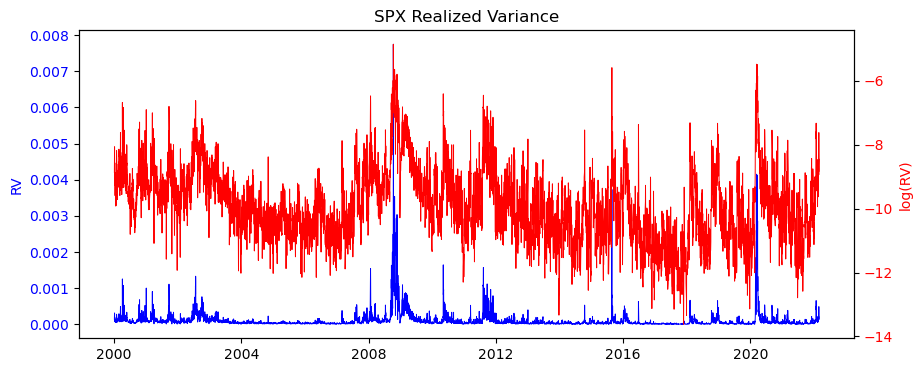

In [10]:
### Plot SPX Realised Volatility
###-------------------------------
# Filter for SPX and get Realized Variance (using rv5)
spx_data = full_data[full_data['Symbol'] == '.SPX'].copy()
# rv_col = 'rk_th2' 
rv_col = 'rv5'
spx_rk = spx_data[rv_col]

# plt.figure(figsize=(10,4))
# plt.plot(spx_rk.index, spx_rk, color='tab:blue', linewidth=0.7)
# plt.title(' SPX Realized Variance')
# plt.ylabel('RV')
# plt.xlabel('Year')
# plt.show()

# plt.figure(figsize=(10,4))
# plt.plot(spx_rk.index, np.log(spx_rk), color='tab:blue', linewidth=0.7)
# plt.title('Log of SPX Realized Variance')
# plt.ylabel('log(RV)')
# plt.xlabel('Year')
# plt.show()

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(spx_rk.index, spx_rk, 'b-', linewidth=0.7)  # Realised variance
# ax1.plot(spx_rk.index, np.sqrt(spx_rk), 'b-', linewidth=0.7) # Realised volatility
ax1.set_ylabel('RV', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(spx_rk.index, np.log(spx_rk), 'r-', linewidth=0.7) # Realised variance
# ax2.plot(spx_rk.index, np.log(np.sqrt(spx_rk)), 'r-', linewidth=0.7) # Realised volatility
ax2.set_ylabel('log(RV)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('SPX Realized Variance')
plt.xlabel('Year')
plt.savefig(f"{dir}/fig_1.png", dpi=200, bbox_inches='tight', 
            pad_inches=0.1, facecolor='white', edgecolor='none')

plt.show()

---
### Scaling of the volatility process

For $q\geq 0$, we define the $q$'th sample moment of differences of log-volatility at a given lag $\Delta$:

$$
m(q,\Delta) = \langle \left| \log \sigma_{t+\Delta} - \log \sigma_t \right|^q \rangle

$$

For example

$$
m(2,\Delta)=\langle \left(\log \sigma_{t+\Delta} -\log \sigma_{t} \right)^2\rangle
$$

is just the sample variance of differences in log-volatility at the lag $\Delta$.




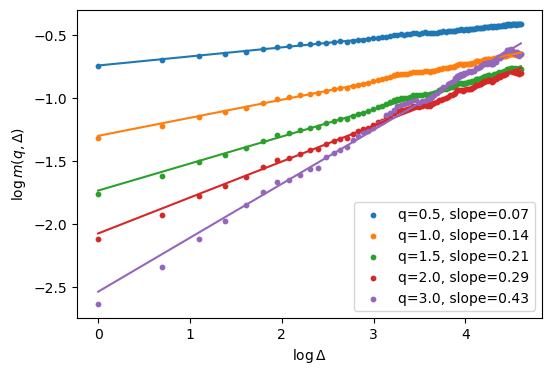

In [16]:
## SCALING OF THE VOLATILITY PROCESS
## ---------------------------------

def calculate_mq_delta(series, q, lags):
    """
    Calculates m(q, Delta) = mean( |log(sigma_{t+Delta}) - log(sigma_t)|^q )
    """
    # Volatility is sqrt(Variance)
    log_sig = np.log(np.sqrt(series)) # log(volatility) # volatility = sqrt(Realised Variance)
    
    m_q = []
    for lag in lags:
        diffs = log_sig.diff(lag).dropna()
        mean_moment = np.mean(np.abs(diffs)**q)  # averaging over time t
        m_q.append(mean_moment)
    return np.array(m_q)

# arrange lags and q-values
lags = np.arange(1, 101)
qs = [0.5, 1.0, 1.5, 2.0, 3.0]

zeta_q = []

plt.figure(figsize=(6,4))

## plotting log(m(q, Delta)) vs log(Delta)
for q in qs:
    m_vals = calculate_mq_delta(spx_rk, q, lags)
    
    ## Regression
    log_lags = np.log(lags)
    log_m = np.log(m_vals)
    slope, intercept, _, _, _ = stats.linregress(log_lags, log_m)
    zeta_q.append(slope)
    
    plt.scatter(log_lags, log_m, s=10, label=f'q={q}, slope={slope:.2f}')
    plt.plot(log_lags, intercept + slope * log_lags)

plt.xlabel(r'$\log \Delta$')
plt.ylabel(r'$\log m(q, \Delta)$')
plt.legend()

plt.savefig(f"{dir}/fig_2.png", dpi=200, bbox_inches='tight',
            pad_inches=0.1, facecolor='white', edgecolor='none')
plt.show()

In [18]:
print("qH vec:",np.array(zeta_q))
print("Herst exponent:", np.array(zeta_q)/qs)

qH vec: [0.07199401 0.14333211 0.21428728 0.28519033 0.42784537]
Herst exponent: [0.14398802 0.14333211 0.14285818 0.14259516 0.14261512]


---
### Monofractal scaling

- From the above log-log plot, we see that for each $q$, $m(q,\Delta) \propto \Delta ^{\zeta_q}$.

- How does $\zeta_q$ scale with $q$?

**Scaling of $\zeta_q$ with $q$ ??**

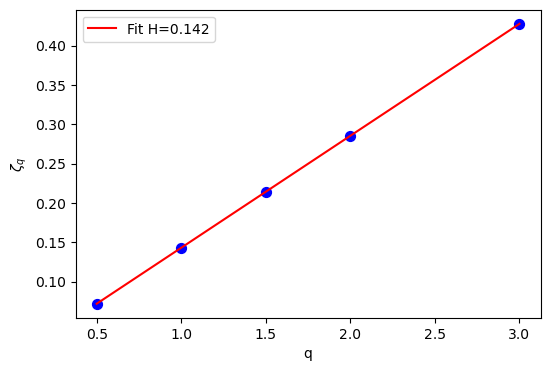

Estimated H from scaling: 0.1423


In [19]:
### MONOFRACTAL SCALING CHECK
##--------------------------

plt.figure(figsize=(6,4))
plt.scatter(qs, zeta_q, color='blue', s=50)

slope_h, intercept_h, _, _, _ = stats.linregress(qs, zeta_q)

plt.plot(qs, [slope_h * x + intercept_h for x in qs], 'r-', label=f'Fit H={slope_h:.3f}')
# plt.title(r'Scaling of $\zeta_q$ with $q$')
plt.xlabel('q')
plt.ylabel(r'$\zeta_q$')
plt.legend()

plt.savefig(f"{dir}/fig_3.png", dpi=200, bbox_inches='tight',
            pad_inches=0.1, facecolor='white', edgecolor='none')

plt.show()

print(f"Estimated H from scaling: {slope_h:.4f}")